# Project 1: Plastic cap liner inspection

GOAL: develop a program to locate defects in the liner of a plastic cap.

A sample of 16 grey scale images has been provided, containing both good and defective samples. The detailed description of the content of this notebook is reported in the homonymous section of the attached report.

In [19]:
# Load necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
import operator

from src.utils import *
import src.config as config

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Read images

Images are stored in a dictionary and a Dataframe, containing images classes and features, is created.

In [20]:
df = create_df(config.path)
image_collection = read_img_gs(config.path)
df.head()

,image,class,defect
0,d_16.bmp,defective,-
1,d_17.bmp,defective,incomplete_liner
2,d_18.bmp,defective,incomplete_liner
3,d_19.bmp,defective,incomplete_liner
4,d_20.bmp,defective,incomplete_liner


#### Select image to work on, es. 'd_16.bmp', or uncomment the following cell and process all images in batch.

Results are stored in the "res" folder, while data in df DataFrame.

Processing d_16.bmp
Processing d_17.bmp
Processing d_18.bmp
Processing d_19.bmp
Processing d_20.bmp
Processing d_21.bmp
Processing d_22.bmp
Processing d_23.bmp
Processing d_24.bmp
Processing d_31.bmp
No liner detected in d_31.bmp
Processing g_01.bmp
Processing g_02.bmp
Processing g_03.bmp
Processing g_04.bmp
Processing g_05.bmp
Processing g_06.bmp
Mean average brightness: 72.8
Avg brightness std dev.: 0.83
      image      class            defect   detected_defect  cap_a  cap_b  \
0  d_16.bmp  defective                 -                 -    386    292   
1  d_17.bmp  defective  incomplete_liner  incomplete liner    386    286   
2  d_18.bmp  defective  incomplete_liner  incomplete liner    384    288   
3  d_19.bmp  defective  incomplete_liner  incomplete liner    382    288   
4  d_20.bmp  defective  incomplete_liner  incomplete liner    384    290   

   cap_r  avg_brightness                                              bbox  \
0    254            72.0                               

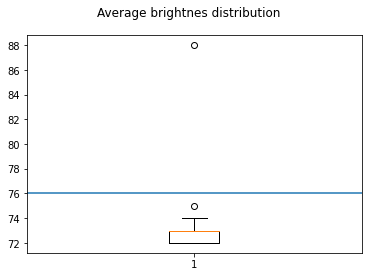

In [27]:
df_processed = process_all(df, image_collection, 'mlht', print_plot=False)
print(df_processed.head())

v = np.array(df_processed['avg_brightness'][df_processed['defect']!='missing_liner'])
config.avg_brightness = np.ceil(np.mean(v) + 3*np.std(v))

avg_bri_vec = np.array(df_processed['avg_brightness'])

fig = plt.figure()
fig.suptitle('Average brightnes distribution')
plt.boxplot(avg_bri_vec)
plt.axhline(config.avg_brightness)
plt.show()


#### From here on this notebook works on a single image, for demo purposes.

Select the image under analysis through the variable "testing_image"

In [38]:
testing_image = 'd_17.bmp'
img = image_collection[testing_image].copy()
# cv2.imwrite(f'{config.report_img_path}d_31.jpg', img) per report
cv2.imshow('img',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

## 2. Cap detection

In this section cap circumference is detected through Circle Hough Transform.

Configuratoin parameters have been determined by experiments and qualitative assesments, because no ground truth was provided.

Circles detection is accomplished throug OpenCV HoughCircles function. Its argument are:
- image: 8-bit, single channel image;
- method: defines the method to detect circles in images. Currently, the only implemented method is cv2.HOUGH_GRADIENT, which corresponds to the Yuen et al. paper.
- dp: this parameter is the inverse ratio of the accumulator resolution to the image resolution (see Yuen et al. for more details). Essentially, the larger the dp gets, the smaller the accumulator array gets.
- minDist: Minimum distance between the center (x, y) coordinates of detected circles. If the minDist is too small, multiple circles in the same neighborhood as the original may be (falsely) detected. If the minDist is too large, then some circles may not be detected at all.
- param1: First method-specific parameter. In case of HOUGH_GRADIENT , it is the higher threshold of the two passed to the Canny edge detector (the lower one is twice smaller).
- param2: Accumulator threshold value for the cv2.HOUGH_GRADIENT method. The smaller the threshold is, the more circles will be detected (including false circles).
- minRadius: Minimum size of the radius (in pixels).
- maxRadius: Maximum size of the radius (in pixels).

In [55]:
# Cap detection
cap = single_detect_circles(img, config.cap_minDist, config.cap_param1, config.cap_param2, config.cap_minRadius, config.cap_maxRadius, print_result=False, show=True)
cap_a, cap_b ,cap_r = cap

print(f'Cap center = ({cap_a},{cap_b})')
print(f'Cap radius = {cap_r}px')

Cap center = (386,286)
Cap radius = 255px


## 3. Missing liner detection

In order to segregate missing liner caps from the rest, one key indicator is the average brightness of the cap itself: indeed, being the cap white and the liner grey, caps without the liner appear brighter in terms of gray levels.

The threshold that allows to classify missing liner caps has been determined statiscally by looking at the whole provided set, after removing "missing_liner" samples, in order to get the $\mu$ and $\sigma$ of the remaining set. This step has to be imagined as happening before the processing pipeline, and its result is then used to classify images in the on-line phase.

It is worth to notice that here, average brightness refers to the average brightness of the cap and **not of the image**. Indeed it is computed after masking the image by removing everything outside it. 

The chosen threshold is the value at $3\sigma$ distance from the sample mean $\mu$, and it is equal to 76.

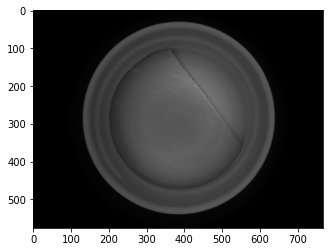

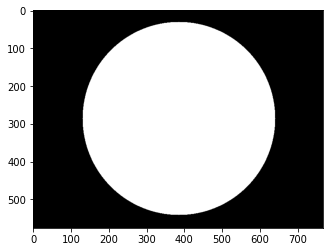

In [41]:
# Generate and use a mask to mask what's outside the cap
mask = np.zeros(img.shape, dtype=np.uint8)
mask = cv2.circle(mask, (cap_a, cap_b), cap_r, 255, -1)

plt.close()
plt.figure()
plt.imshow(mask,cmap='gray',vmin=0,vmax=255)

plt.figure()
plt.imshow(img, cmap='gray',vmin=0,vmax=255)

Average brightness = 75.0


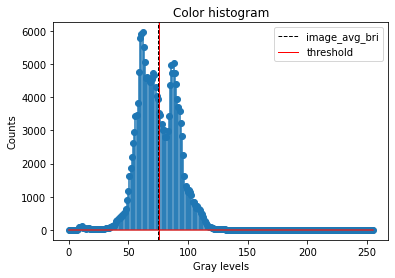

In [42]:
# Computing and plotting masked image average brightness

avg_bri = compute_avg_brightness(img, mask)
print(f'Average brightness = {np.round(avg_bri,0)}')
hist = print_hist(img, mask, avg_bri)

## 4. Missing liner images classification

In [43]:
# Classification based on threshold on average brightness.

if avg_bri > config.avg_brightness:
    has_liner = False
else:
    has_liner = True

## 5. Liner detection

As previously stated for cap detection, in this section liner circumference is detected through Circle Hough Transform.

Again, configuratoin parameters have been determined by experiments and qualitative assesments, because no ground truth was provided.

Steps that follow are applied only to images **with** liner.

In [54]:
if has_liner:

    ## Liner detection
    liner = single_detect_circles(img, config.liner_minDist, config.liner_param1, config.liner_param2, config.liner_minRadius, config.liner_maxRadius, print_result=False, show=True, save_img_as='liner_circle.jpg')

    liner_a, liner_b ,liner_r = liner
    print(f'Liner center = ({liner_a},{liner_b})')
    print(f'Liner radius = {liner_r}px')
else:
    raise SystemExit("No liner found! Stopping here...")

Liner center = (388,284)
Liner radius = 185px


## 6. Defect detection

Missing liner defects are discovered by running a Canny edge detector in the liner region and counting the number of non zero pixels. In other words, defects are here treated as edges that "shouldn't be there".

In [46]:
edged_full, edge_only = check_defect_circular_region(img, config.canny_lower, config.canny_upper, [liner_a, liner_b, liner_r], show=True)

In [14]:
# Check if there are edges
defect = False
whites = np.sum(edge_only.flatten())
print(whites)
if whites > config.defect_t:
    defect = True
print(defect)

99705
True


## 7. Defect bounding box

At the end, a bounding box is drawn around the defect's edge. The following cell implements three different methods:
- baseline: uses Canny's output of the previous step to derive defect's contour and draw the minimum enclosing rectangle around it;
- slht: "single line Hough transform" exploits Hough transform to detect lines that corresponds to the defect, chooses the longest one and uses it to draw the minimum enclosing rectangle;
- mlht: "multiple lines Hough transform" exploits Hough transform to detect lines that corresponds to the defect and uses all of them to draw the minimum enclosing rectangle.

The latter method, by relying on multiple lines, draws slightly larger bound boxes.

The assumption the latter two methods is that defects are always stright (more or less), due to manufacturing reasons.
However, MLHT could in principle work also for non straight defects, by approximating them through a sequence of small lines.

In [17]:
# Defect highlighting
defect_hl_method = 'mlht'

# BBOX
if defect:
    ## Common
    result = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)
    if defect_hl_method == 'baseline':

        # baseline
        cnt = baseline_contours_finder(edge_only)   

    elif defect_hl_method == 'slht':

        # Hough Transform single line detection
        cnt, lines_img = slht_contours(edged_full)

        cv2.imshow('Detected lines', lines_img)
        # cv2.imwrite(f'{config.report_img_path}LHT_line.jpg', lines_img)

        cv2.waitKey(0)

    elif defect_hl_method == 'mlht':

        # Hough Transform multiple lines detection
        cnt, lines_img = mlht_contours(edged_full)

        cv2.imshow('Detected lines', lines_img)
        # cv2.imwrite(f'{config.report_img_path}LHT_lines.jpg', lines_img)
        cv2.waitKey(0)


    # common
    result, _ = draw_rect(result, cnt)

    cv2.imshow(f"{defect_hl_method} edge finder", result)
    cv2.imwrite(f'{config.report_img_path}p1_final.jpg', result)
    cv2.waitKey(0)
    cv2.destroyAllWindows()